In [1]:
from sklearn.model_selection import train_test_split
import utils
import pandas as pd
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_metabric(missing_values_strategy="mean", gene_data=False):
    df = utils.get_unprocessed_metabric()[0]
    df["Event"] = df["Patient's Vital Status"] != "Living"
    gene_df = pd.read_csv("brca_metabric/data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt", sep="\t")
    gene_df = gene_df.set_index('Hugo_Symbol').transpose()
    gene_df = gene_df.iloc[1:]
    df = df.merge(gene_df, left_on='Patient ID', right_index=True)
    
    df_clear = utils.handle_missing_values(df, missing_values_strategy)
    df_clear = df_clear.drop(["Study ID", "Patient ID", "Sample ID","Overall Survival Status", "Patient's Vital Status", "Cancer Type", "Number of Samples Per Patient", "Sex", "Sample Type"
    , "Cancer Type Detailed", "Tumor Other Histologic Subtype", "Oncotree Code", "Relapse Free Status", "Relapse Free Status (Months)", "TMB (nonsynonymous)", "Mutation Count", "Neoplasm Histologic Grade"], axis = 1)
    
    values = df_clear["Integrative Cluster"].values
    new_values = ["6" if x == "6" else "other" for x in values]
    df_clear["Integrative Cluster"] = new_values

    df_clear["HER2 status measured by SNP6"] = df_clear["HER2 status measured by SNP6"].replace("UNDEF", "AUNDEF")
    df_clear["Pam50 + Claudin-low subtype"] = df_clear["Pam50 + Claudin-low subtype"].replace("NC", "ANC")
    df_clear = pd.get_dummies(df_clear, drop_first=True)
    return df_clear, "Event", "Overall Survival (Months)"

In [3]:
df, event_col, duration_col = get_metabric()
df_train, df_test = utils.split_dataset(df)
df_train, df_valid = utils.split_dataset(df_train)

g:\DL\Deep-Learning-In-Survival-Analysis\utils.py:123: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return df.fillna(df.mean())


In [4]:
col_to_score = {}
for column in df_train.columns:
    if column not in [event_col, duration_col]:
        df_sub = df_train[[event_col, duration_col, column]]
        cph = CoxPHFitter(penalizer=0.1)
        cph.fit(df_sub, duration_col = duration_col, event_col = event_col)
        concordance_index = cph.score(df_valid[[event_col, duration_col, column]], scoring_method="concordance_index")
        col_to_score[column] = concordance_index

In [5]:
sorted_cols = sorted(col_to_score.items(), key=lambda x: x[1], reverse=True)
sorted_cols_names = [x[0] for x in sorted_cols]

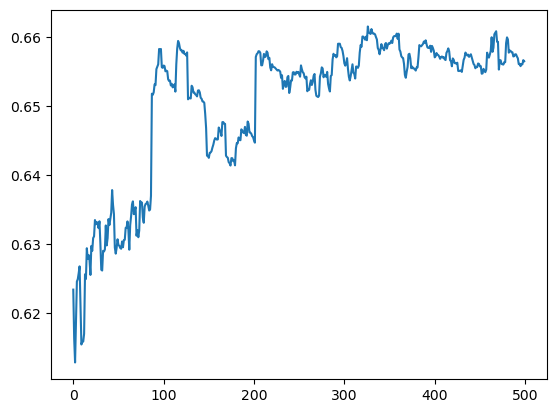

In [6]:
concordance_indexes = []
for i in range(500):    
    picked_cols = [event_col, duration_col] + sorted_cols_names[:i+1]

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(df_train[picked_cols], duration_col = duration_col, event_col = event_col)
    concordance_index = cph.score(df_test[picked_cols], scoring_method="concordance_index")
    concordance_indexes.append(concordance_index)
plt.plot(concordance_indexes)

In [7]:
print(f'Best concordance index: {np.max(concordance_indexes)}, num features {np.argmax(concordance_indexes)}')
concordance_indexes[180]

Best concordance index: 0.6615857996585088, num features 326


0.6438887307911212

In [8]:
cph = CoxPHFitter(penalizer=0.1)
picked_cols = [event_col, duration_col] + sorted_cols_names[:180]
df_train_and_valid = pd.concat([df_train, df_valid])
cph.fit(df_train_and_valid[picked_cols], duration_col = duration_col, event_col = event_col)
concordance_index = cph.score(df_test[picked_cols], scoring_method="concordance_index")
print(f'Best concordance index: {concordance_index}, num features {len(picked_cols)}')
summary = cph.summary.copy()
cols_mask = [True] * len(summary.index.values)

Best concordance index: 0.6576195219123506, num features 182


In [9]:
summary = cph.summary.copy()
cols_mask = [True] * len(summary.index.values)
while True:
    used_columns = list(summary.index.values[cols_mask]) + [event_col, duration_col]
    
    cph_tune = CoxPHFitter(penalizer=0.1)
    cph_tune.fit(df_train[used_columns], duration_col = duration_col, event_col = event_col)
    best_concordance_index = cph_tune.score(df_valid[used_columns], scoring_method="concordance_index")
    
    summary = cph_tune.summary.copy()
    cols_mask = [True] * len(summary.index.values)
    i=0
    while True:
        summary = summary.sort_values(by="p", ascending=False)
        cols_mask[i] = False
        summary.index.values[cols_mask]
        cph_tune = CoxPHFitter(penalizer=0.1)
        used_columns = list(summary.index.values[cols_mask]) + [event_col, duration_col]
        cph_tune.fit(df_train[used_columns], duration_col = duration_col, event_col = event_col)
        concordance_index = cph_tune.score(df_valid[used_columns], scoring_method="concordance_index")
        if concordance_index > best_concordance_index:
            best_concordance_index = concordance_index
            print(f'Best concordance index: {concordance_index}, num features {len(summary.index.values[cols_mask])}')
            break
        else:
            cols_mask[i] = True
        i += 1
        if i == len(cols_mask):
            break
    if i == len(cols_mask):
        break



Best concordance index: 0.6952074032463117, num features 179
Best concordance index: 0.695355231647104, num features 178
Best concordance index: 0.695414363007421, num features 177
Best concordance index: 0.695473494367738, num features 176
Best concordance index: 0.6955917570883718, num features 175
Best concordance index: 0.6956508884486887, num features 174
Best concordance index: 0.6956804541288473, num features 173
Best concordance index: 0.6957987168494811, num features 172
Best concordance index: 0.695857848209798, num features 171
Best concordance index: 0.695916979570115, num features 170
Best concordance index: 0.6959465452502734, num features 169
Best concordance index: 0.6961830706915413, num features 168
Best concordance index: 0.6963308990923336, num features 167
Best concordance index: 0.696419596132809, num features 166
Best concordance index: 0.696478727493126, num features 165
Best concordance index: 0.6965082931732844, num features 164
Best concordance index: 0.69656

In [12]:
used_columns

['CDC45',
 'ITGA10',
 'MAP4K2',
 'MYL5',
 'IQUB',
 'C1QC',
 'CCT6B',
 'CENPP',
 'TUBA3E',
 'OPRL1',
 'CDT1',
 'DNAJB11',
 'SLC24A2',
 'MKI67',
 'LZTFL1',
 'WDR19',
 'H2BC7',
 'CENPI',
 'GSTM4',
 'CLIC6',
 'TRIM4',
 'CFAP70',
 'GPR4',
 'PLK1',
 'FLT3',
 'RBP7',
 'ENC1',
 'LARP1',
 'Event',
 'Overall Survival (Months)']